## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
%matplotlib qt



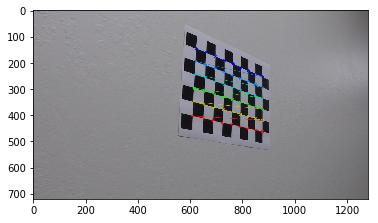

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img) 
        

In [3]:
#1. Used Glob function to read all the calibation image files in Images
#2. Identified and extracted the object and image points

## Undistort Chessboard

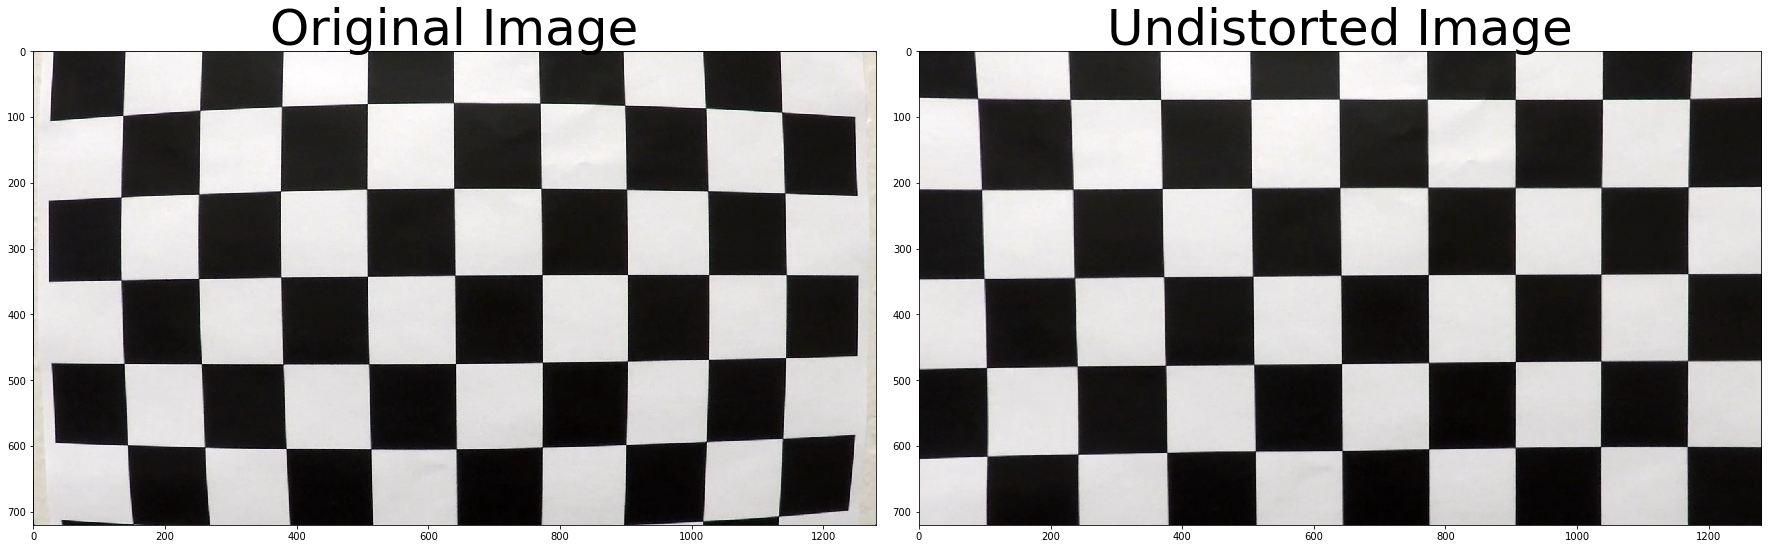

In [4]:
img = mpimg.imread('camera_cal/calibration1.jpg')
gray= gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
 #3. used the object and image points to undistort the image

## RAW test image Distortion correction

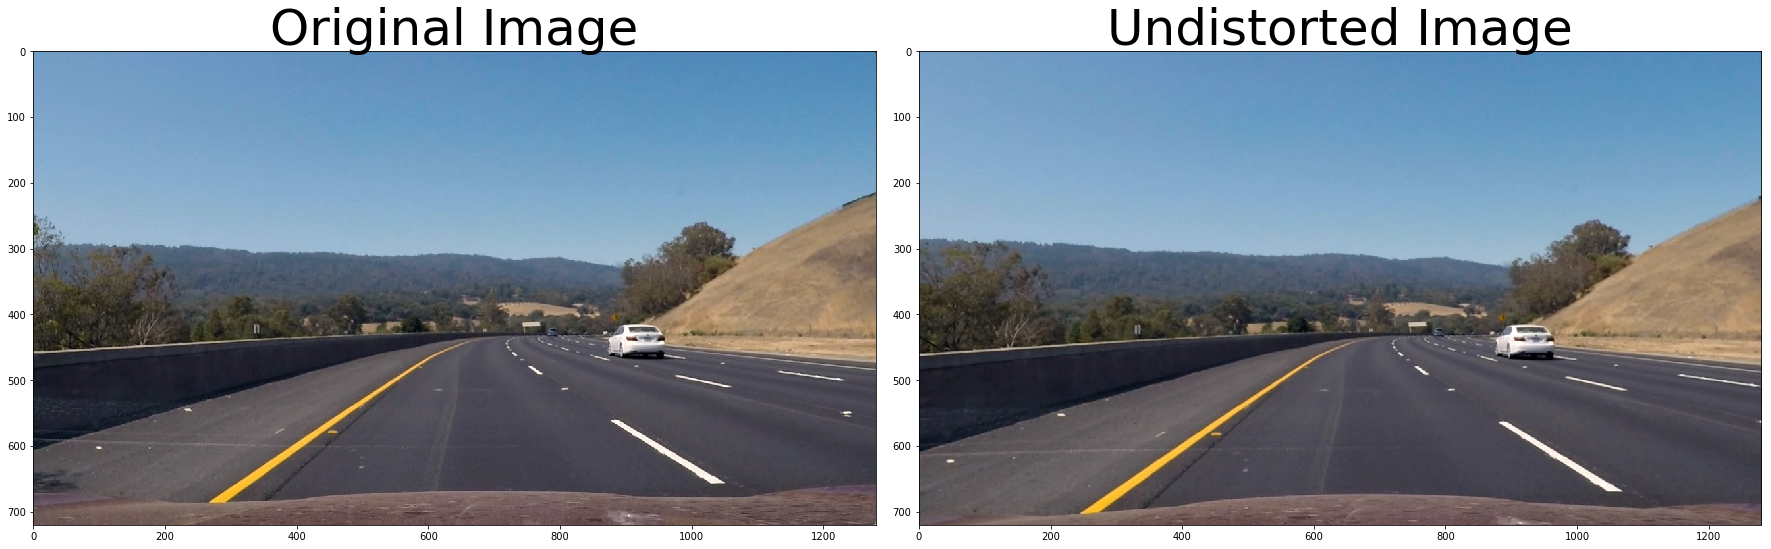

In [6]:
# Applying distortion correction to Raw image
img = mpimg.imread('test_images/test3.jpg')
gray= gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
img_size= (img.shape[1], img.shape[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


##  Directional Gradient

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=10, thresh_max=200):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

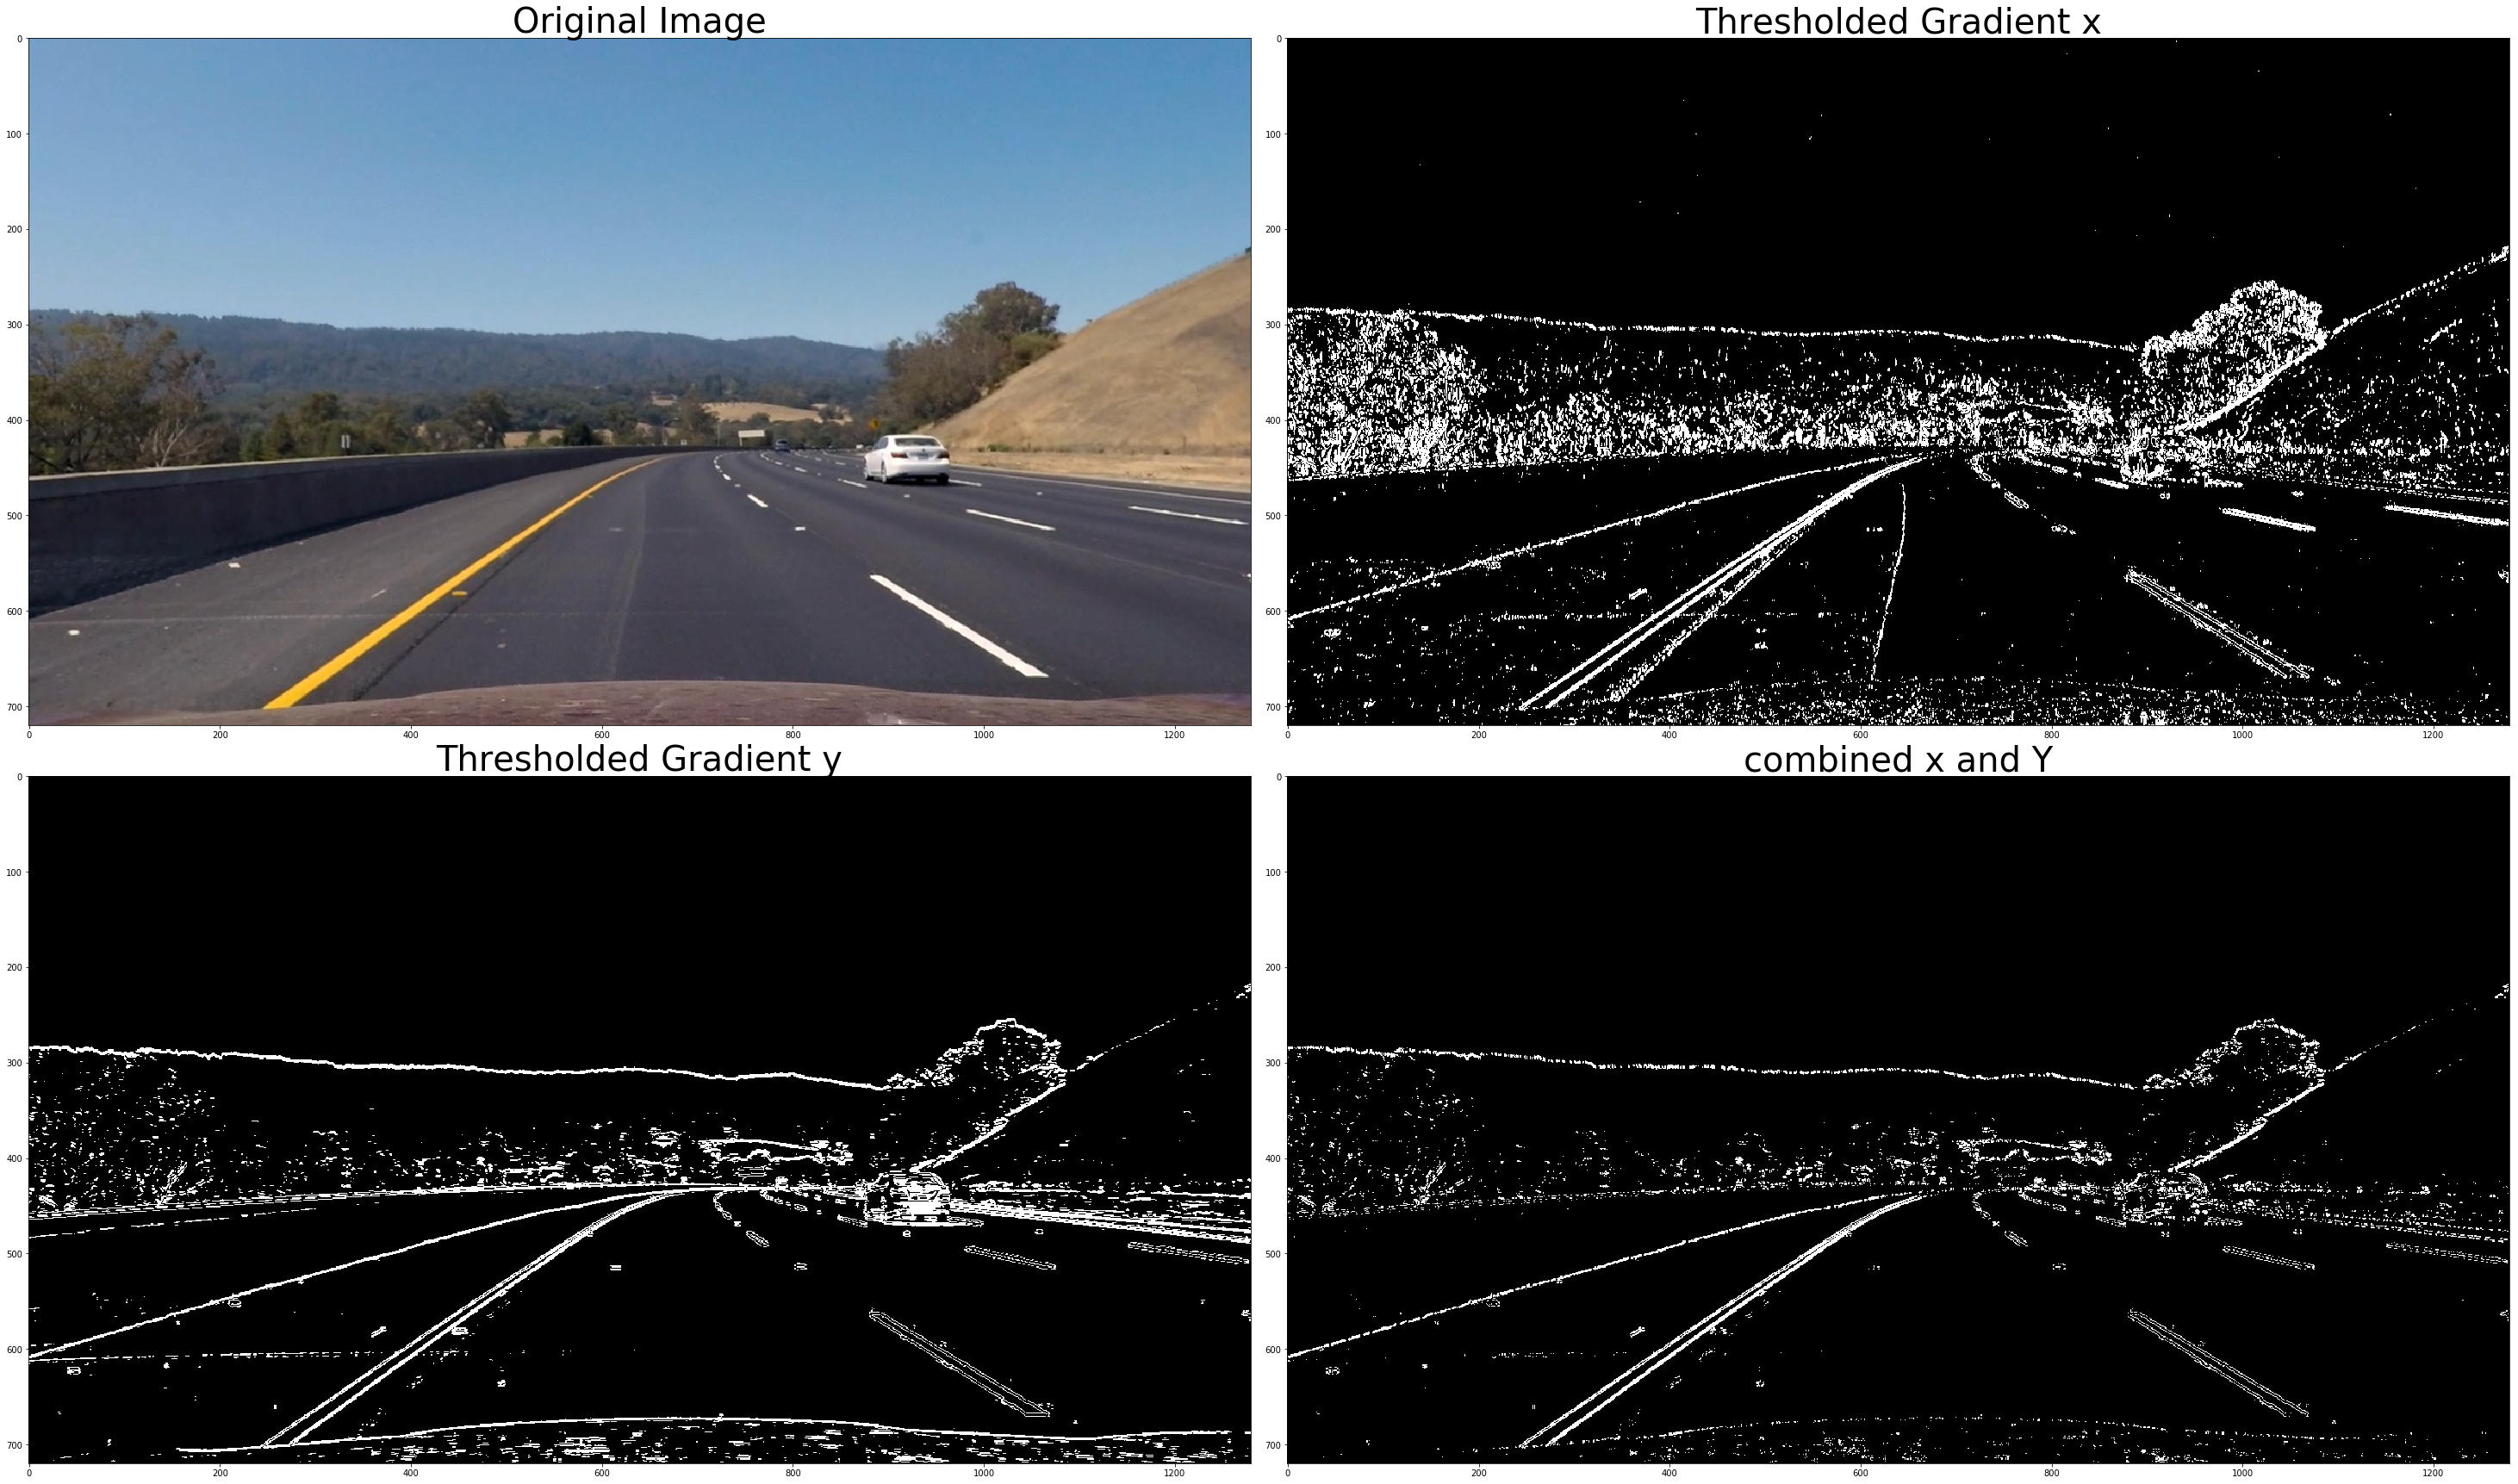

In [8]:
# Run the function
grad_binary_x = abs_sobel_thresh(img, orient='x', thresh_min=9, thresh_max=100)
grad_binary_y = abs_sobel_thresh(img, orient='y', thresh_min=18, thresh_max=100)
combined = np.zeros_like(grad_binary_x)
combined[((grad_binary_x == 1) & (grad_binary_y == 1))] = 1 #| ((mag_binary == 1) & (dir_binary == 1))] = 1
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(40, 26))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient x', fontsize=40)
ax3.imshow(grad_binary_y, cmap='gray')
ax3.set_title('Thresholded Gradient y', fontsize=40)
ax4.imshow(combined, cmap='gray')
ax4.set_title('combined x and Y', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Magnitude Threshold Gradient

In [9]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output  



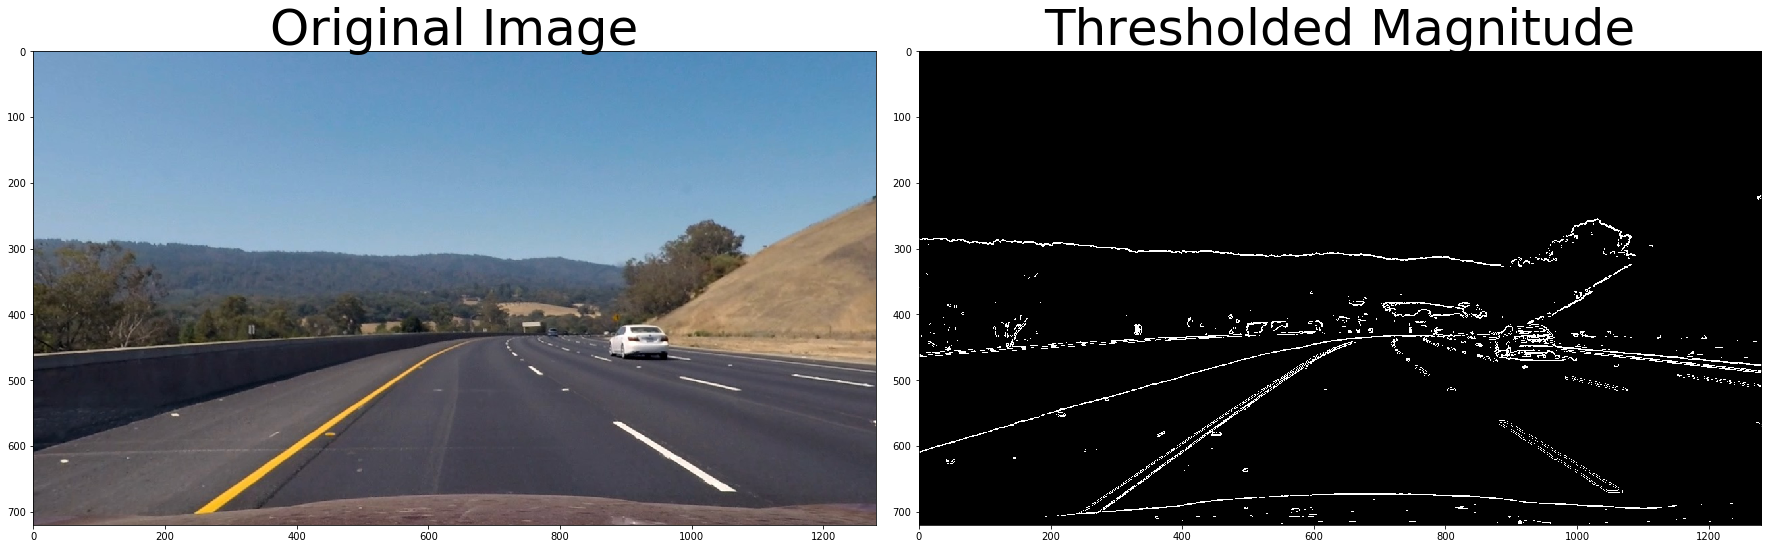

In [10]:
# Run the function
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(40, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Directional Threshold

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(undistorted, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_finale = np.arctan2(abs_sobely, abs_sobelx)
    binary_output =  np.zeros_like(abs_finale)
    binary_output[(abs_finale >= thresh[0]) & (abs_finale <= thresh[1])] = 1
    return binary_output

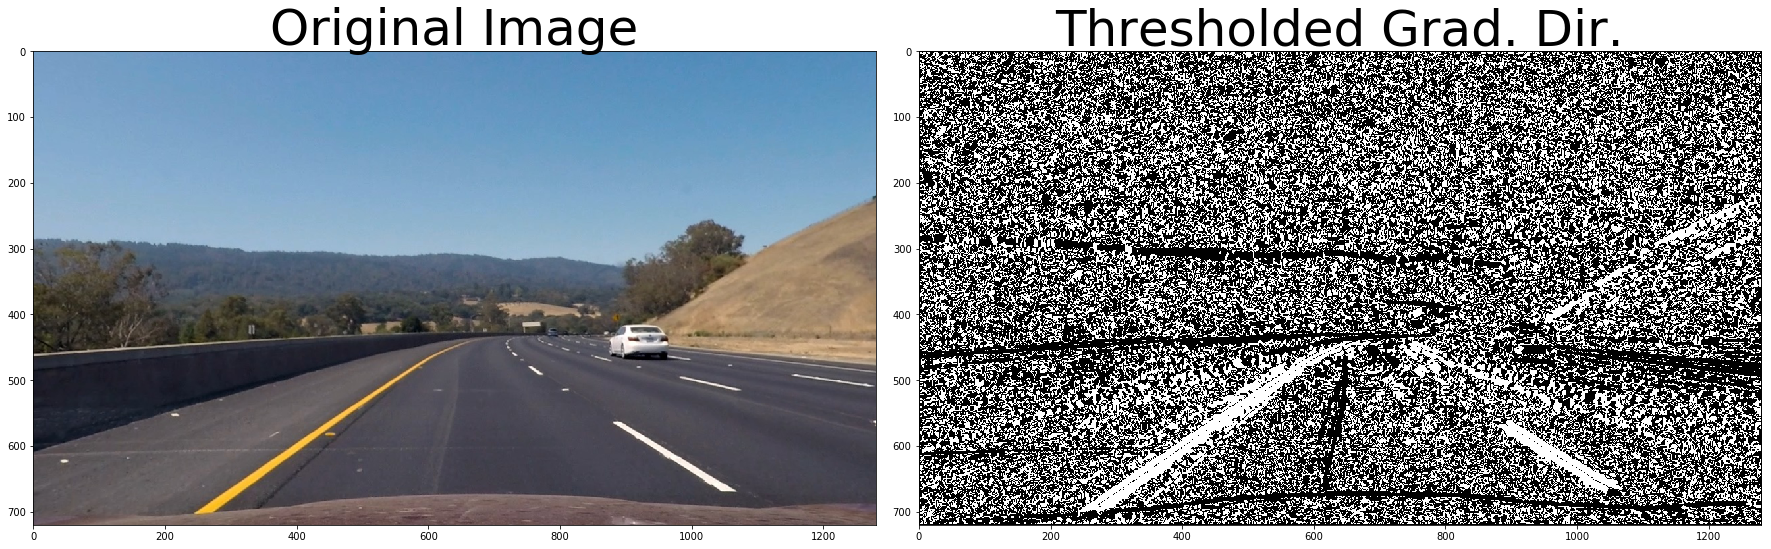

In [12]:
# Run the function
dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [13]:
combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

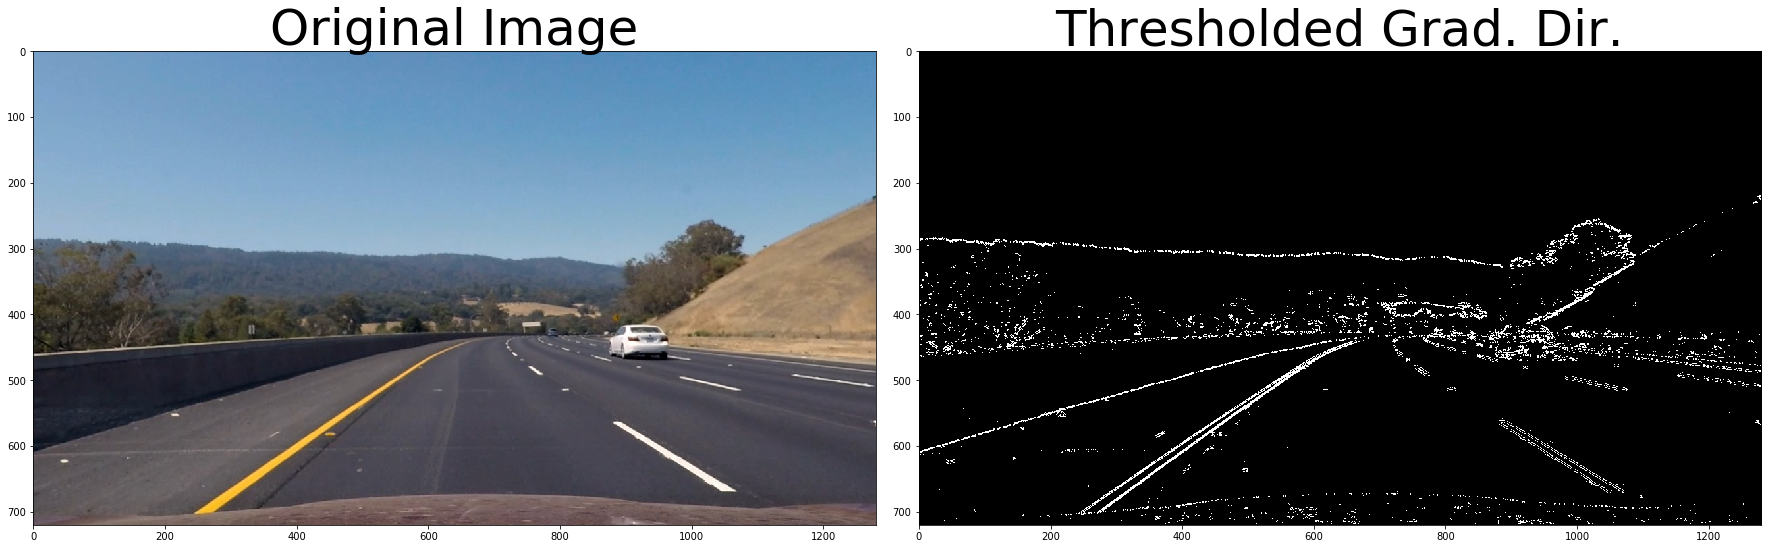

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

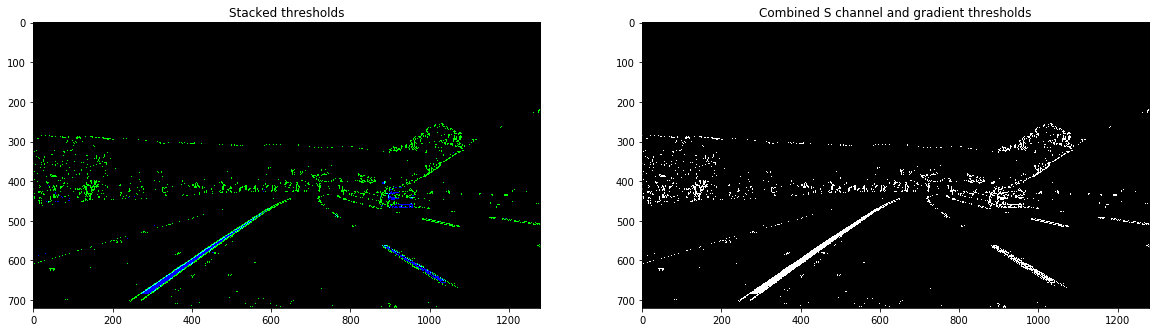

In [15]:
# Use color transforms, gradients, etc., to create a thresholded binary image
def bin_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1

    # Threshold y gradient
    thresh_min = 40
    thresh_max = 100
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 160
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, color_binary

# Plotting thresholded images
combined_binary, color_binary = bin_threshold(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## And so on and so forth...

In [16]:
undis_size= (undistorted.shape[1], undistorted.shape[0])
height = img.shape[0]
def warp(undistorted, undis_size = None):
    
 
    src = np.float32(
        [[200, height],
         [570,470],
         [760,470],
         [1160, height]])
    
    dst = np.float32(
       [[210, height],
        [210, 0], 
        [1100, 0],  
        [1100, height]])
    
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, undis_size, flags=cv2.INTER_LINEAR)
    return warped, src, dst, M

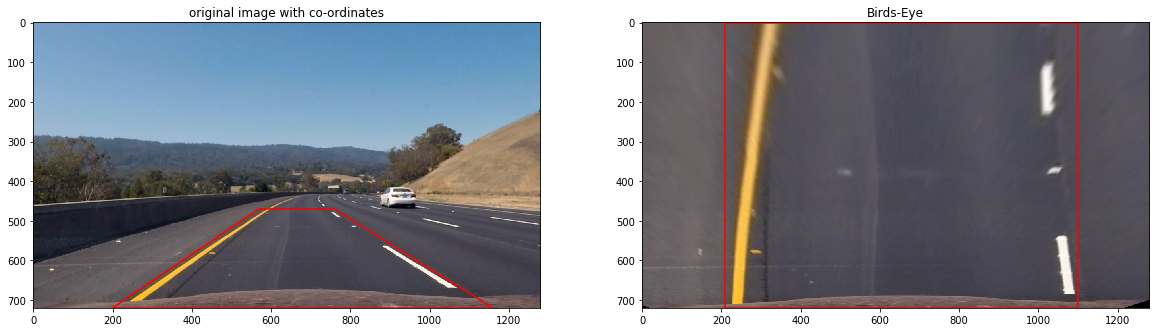

In [17]:
warp_img = warp(undistorted, undis_size)[0]
src = warp(undistorted, undis_size)[1]
dst = warp(undistorted, undis_size)[2]
M = warp(undistorted, undis_size)[3]
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image with co-ordinates')
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(undistorted)

ax2.set_title('Birds-Eye')
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warp_img)

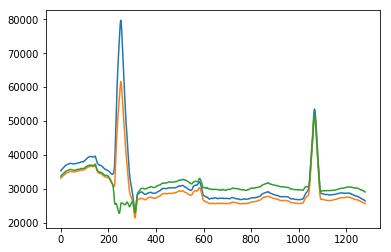

In [18]:
histogram = np.sum(warp_img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [19]:
combin_size= (combined_binary.shape[1], combined_binary.shape[0])

def warp1(combined_binary, combin_size = None):
    
 
    src = np.float32(
        [[200, height],
         [570,470],
         [760,470],
         [1160, height]])
    
    dst = np.float32(
       [[210, height],
        [210, 0], 
        [1100, 0],  
        [1100, height]])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv= cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined_binary, M, combin_size, flags=cv2.INTER_LINEAR)
    return warped, M_inv

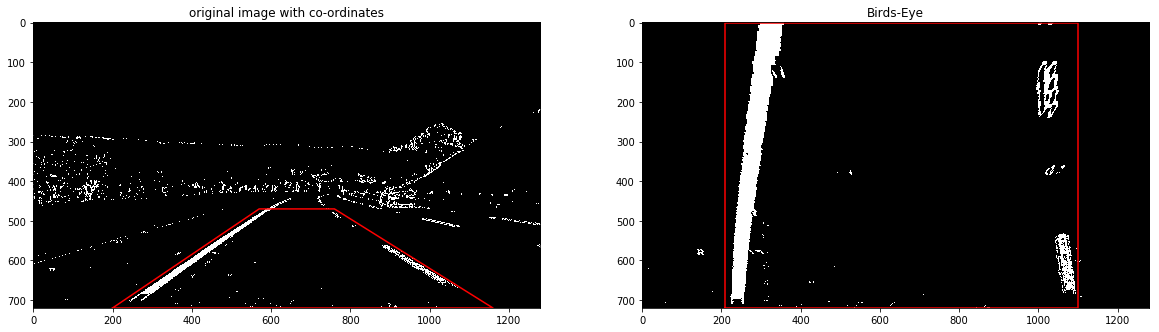

In [20]:
warp1_img = warp1(combined_binary, combin_size = None)[0]
M_inv= warp1(combined_binary, combin_size = None)[1]
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image with co-ordinates')
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Birds-Eye')
ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(warp1_img, cmap='gray')

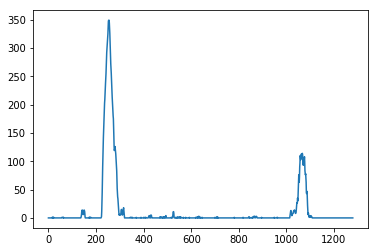

In [21]:
histogram = np.sum(warp1_img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
out_img = np.dstack((warp1_img, warp1_img, warp1_img))*255
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [22]:
def find_lane_pixels(warp1_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warp1_img[warp1_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warp1_img, warp1_img, warp1_img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warp1_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warp1_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warp1_img.shape[0] - (window+1)*window_height
        win_y_high = warp1_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(255,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
      # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
        # If no pixels were found return None
    if(lefty.size == 0 or leftx.size == 0):
        return None, None
    if(righty.size == 0 or rightx.size == 0):
        return None, None

    # Fit the polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty   
    
    return left_fit, right_fit, out_img
    

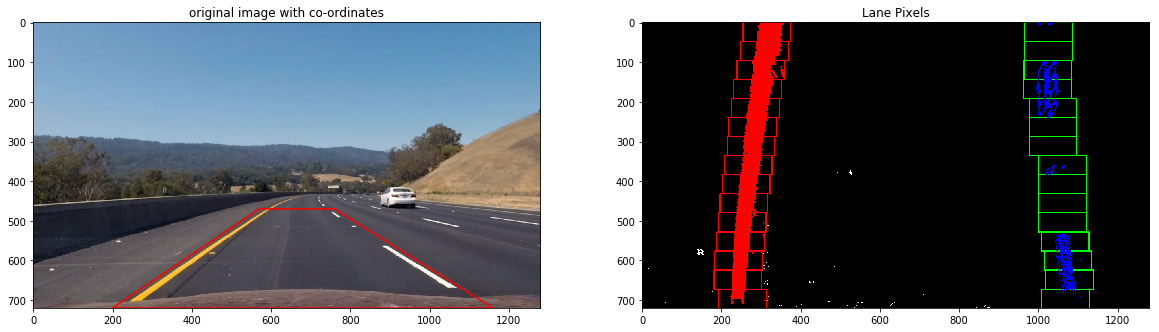

In [23]:
left_fit, right_fit, out_img= find_lane_pixels(warp1_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original image with co-ordinates')
ax1.plot(Polygon(src).get_xy()[:, 0], Polygon(src).get_xy()[:, 1], color='red')
ax1.imshow(undistorted)
ax2.set_title('Lane Pixels')
#ax2.plot(Polygon(dst).get_xy()[:, 0], Polygon(dst).get_xy()[:, 1], color='red')
ax2.imshow(out_img)


In [24]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a blank image to draw on
    out_img = np.dstack((warp1_img, warp1_img, warp1_img))*255
    #out_img = np.dstack((binary_warped[:,:,0], binary_warped[:,:,1], binary_warped[:,:,2]))*255
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    pts= np.hstack((left_line_pts, right_line_pts))
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='white')
    

     # Draw the lane onto the warped blank image
    
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    F_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
         
    
     # Color in left and right line pixels
    F_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
    F_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
        
    # Draw polyline on image
    right = np.asarray(tuple(zip(right_fitx, ploty)), np.int32)
    left = np.asarray(tuple(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(F_img, [right], False, (0,0,100), thickness=50)
    cv2.polylines(F_img, [left], False, (100,100,0), thickness=50)
        
    return F_img, left_fitx, right_fitx

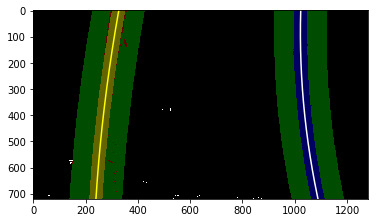

In [25]:
F_img, left_fitx, right_fitx= search_around_poly(warp1_img, left_fit, right_fit)
plt.imshow(F_img)

In [26]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0])
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)


Radius of curvature: 1511.23 m
Center offset: 0.13 m


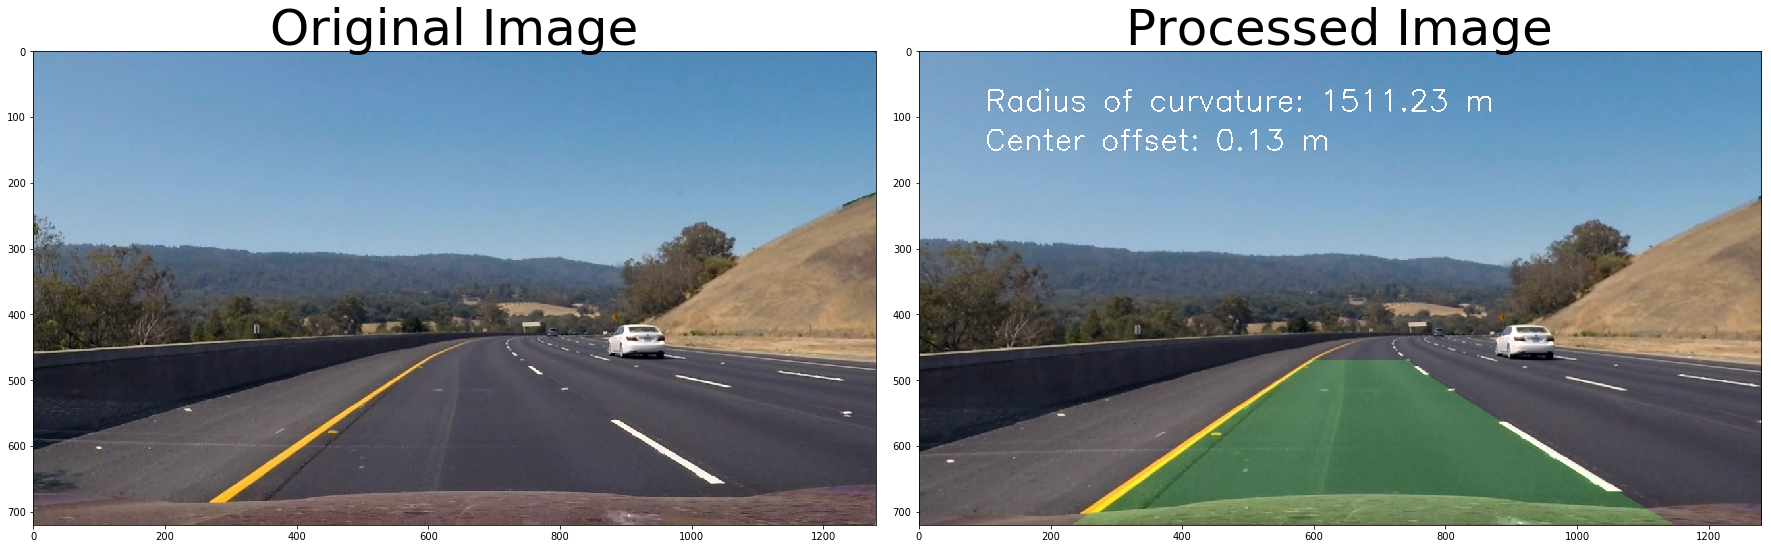

In [27]:
ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0])
left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
line_points = np.vstack((left_line_window, right_line_window))
Zero_img = np.zeros_like(warp_img)
cv2.fillPoly(Zero_img, np.int_([line_points]), [0,150, 0])
unwarped = cv2.warpPerspective(Zero_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [28]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)

        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [29]:
def process_video(img):
   #idx = 1
   # objp = np.zeros((6*9,3), np.float32)
    #objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    global counter 
    counter = 0
    global ref_left 
    global ref_right
    global left_fitx
    global right_fitx
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    #ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    grad_binary_x = abs_sobel_thresh(img, orient='x', thresh_min=9, thresh_max=100)
    grad_binary_y = abs_sobel_thresh(img, orient='y', thresh_min=18, thresh_max=100)
    
    combined_binary, color_binary = bin_threshold(img)
    combin_size= (combined_binary.shape[1], combined_binary.shape[0])
    
    warp1_img = warp1(combined_binary, combin_size = None)[0]
    M_inv= warp1(combined_binary, combin_size = None)[1]
    
    
    
    if counter==0:
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        left_fit, right_fit, out_img= find_lane_pixels(warp1_img)
        ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
      #  F_img, left_fitx, right_fitx = search_around_poly(combined_binary, left_fit, right_fit)
       
    else:
        F_img, left_fitx, right_fitx = search_around_poly(combined_binary, left_fit, right_fit)
    
    #Project video (2.8, 3.5)
    status_sanity, d0, d1 =sanity_check(left_fitx, right_fitx, 0, .55)
    #Challenge video (2.4,3.1)
    #status_sanity, d0, d1, d2 =sanity_check(left_fit, right_fit, 2.4,3.1)
    
    #print(left_fit)
    #print(right_fit)
    ref_left, ref_right = left_fitx, right_fitx
    #Calc curvature and center
    if status_sanity  == True:        
        #Save as last reliable fit
        ref_left, ref_right = left_fitx, right_fitx        
        counter+=1
    else:        #Use the last realible fit
        left_fitx, right_fitx = ref_left, ref_right
    
    
        
    # new_warp = cv2.warpPerspective(F_img, M_inv, (combined_binary.shape[1], combined_binary.shape[0]))
    
    #F_result = cv2.addWeighted(undistorted, 1, new_warp, 0.5, 0)
   
    ploty = np.linspace(0, warp1_img.shape[0]-1, warp1_img.shape[0])
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    line_points = np.vstack((left_line_window, right_line_window))
    Zero_img = np.zeros_like(warp_img)
    cv2.fillPoly(Zero_img, np.int_([line_points]), [0,150, 0])
    unwarped = cv2.warpPerspective(Zero_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
    
    
    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs


    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2) 
    #cv2.putText(result, left_fitx, (100, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2) 
        
    return result



In [30]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5.1)
#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_video)
white_clip.write_videofile(output, audio=False) 


Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4


In [31]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [32]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip
output = 'challenge_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,2.1)
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(0,5.1)
white_clip = clip1.fl_image(process_video)
white_clip.write_videofile(output, audio=False) 

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4


In [33]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [34]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip
output = 'Harder_challenge_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,2.1)
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,5.1)
white_clip = clip1.fl_image(process_video)
white_clip.write_videofile(output, audio=False) 

Moviepy - Building video Harder_challenge_video_output.mp4.
Moviepy - Writing video Harder_challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready Harder_challenge_video_output.mp4


In [35]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))